# Import Libraries

In [20]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import spell
import re
from itertools import chain
import seaborn as sns

# Function to Seperate Sentence from Paragraph

In [21]:
def chains(para):
    return list(chain.from_iterable(para.str.split('.')))

# Function to Clean & Process Data

In [22]:
def process_data(df):
    
    df = df.dropna() # Drop all NaN value
    
    # Seperate Sentence from Paragraph
    length = df['comment'].str.split('.').map(len)
    data = pd.DataFrame({'user': np.repeat(df['user'], length),'date': np.repeat(df['date'], length),
                         'comment': chains(df['comment'])})
    
    return data

# Function to filter text

In [23]:
def filtered_text(text):
    filter0 = [(t.lower(), tag) for t,tag in text]
    filter1 = [(re.sub("["+"".join(sp)+"+]",' ',f), tag) for f,tag in filter0]    #for removing delimiter and other useless stuff
    filter2 = [(''.join (f), tag) for f,tag in filter1 if not f.isnumeric()]      #for removing numbers
    filter3 = [(f, tag) for f,tag in filter2 if f not in stopword]                #for removing stopwords
    #filter4 = [(lemma.lemmatize(f), tag) for f,tag in filter3]                   #for lemmatizing the words
    return filter3

# Function to Calculate Sentiment Score of a Word

In [24]:
def cal_score(word, tag):
    try:
        s_pos = [] # Positive Score
        s_neg = [] # negative Score
        s_obj = [] # Objective Score
        
        for s in list(swn.senti_synsets(word, tag)):
            s_pos.append(s.pos_score())
            s_neg.append(s.neg_score())
          
            if (s.pos_score() == 0.0 and s.neg_score() == 0.0):
                score = 2 * s.obj_score()
                break
                
        max_pos = max(s_pos)
        max_neg = max(s_neg)
        
        if max_pos > max_neg:
            score = max_pos
        else:
            score = -1*max_neg
    except ValueError:
        score = 0.0
        
    return score

# Function to Calculate Sentiment Score of a Sentence

In [25]:
def cal_senti_score(tokens):
    for text in (tokens):

        tagged_word = nltk.pos_tag(text)                                    # Each Word is tagged with a POS
        filt_word = filtered_text(tagged_word)                 
        score_post = adj_score = adv_score = vb_score = adv_score = 0.0

        for word,tag in filt_word:

            if tag in adv:                                                  # To find Adverb Score
                if tag == 'RBS':
                    adv_score = adv_score + (1.5 * cal_score(word, 'r'))
                elif tag == 'RBR':
                    adv_score = adv_score + (1.2 * cal_score(word, 'r'))
                else:
                    adv_score = adv_score + (1.0 * cal_score(word, 'r'))

            elif tag in adj:                                                # To find Adjective Score
                adj_score = cal_score(word, 'a')
                if tag == 'JJS':
                    score_post = score_post + (0.4 * adv_score + 1) * (1.5 * adj_score)   # 1.5, 1.2, 1.0 are the respective Scaling Factors
                elif tag == 'JJR':
                    score_post = score_post + (0.4 * adv_score + 1) * (1.2 * adj_score)
                else:
                    score_post = score_post + (0.4 * adv_score + 1) * (1.0 * adj_score)
                adv_score = 0.0

            elif tag in vb:                                                 # To find Verb Score
                vb_score = cal_score(word, 'v')
                score_post = score_post + (0.4 * adv_score + 1) * vb_score  # 0.4 is a Scaling Factor
                adv_score = 0.0

        final_score.append(score_post)                                      # Final Sentiment Score of a Sentence

# Function to Calculate Sentiment Score of a Disaster

In [26]:
def final_senti_score(data, df):
    
    tokens = [nltk.word_tokenize(d) for d in data['comment']]                     # Tokenize the Sentence
    cal_senti_score(tokens)
    
    senti_score = pd.Series(final_score)
    data['sentiment_score'] = senti_score.values
    
    senti_data = data.groupby(data.index).sum()
    final_data = df.join(senti_data)
    
    time = final_data['date'].str.split()
    date = []
    for t in time:
        date.append(" ".join(t[0:3]))
    final_data['date'] = date
    
    disaster_senti_score = final_data.groupby(['date', 'user']).mean()['sentiment_score'].sum()
    return disaster_senti_score

# Define Some Variables

In [27]:
 # Create Stopwords
stopword = set(stopwords.words('english')) 
sp_char = ['.','-','*','@','$','%','&', '#',',', '"', "'", '?', '!', ':', ';', ')', ']', '[', '(', '}', '{','1','2','3','4','5','6','7','8','9',' ','  ','   ','~','`','|','/']
sp = ['.','*','-','@','$','%','&', '#',',', '"', "'", '?', '!', ':', ';', ')', '(', '}', '{','1','2','3','4','5','6','7','8','9','~','`','|','/']
stopword.update(sp_char)
lemma = WordNetLemmatizer()

adj = ['JJ', 'JJR', 'JJS']                      # All Adjective POS Tags
#noun = ['NN', 'NNP', 'NNPS', 'NNS']            # All Noun POS Tags
adv = ['RB', 'RBR', 'RBS']                      # All Adverb POS Tags
vb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']  # All verb POS Tags
final_score = []

# Load Data

In [28]:
data = pd.read_csv("Japan2016_Earthquake.csv")

In [29]:
data.head()

,user,date,comment
0,StuOnTour,11/22/2016,Tokyo here - woke up just before 6AM with some...
1,Mr-Thumpasaurus,11/22/2016,Just wanted to weigh in on this one - Sounds l...
2,forty_two_monkeys,11/22/2016,You can see the water retracting on the NHK li...
3,Nukemarine,11/22/2016,"Currently, I'm about 320 km south of Fukushima..."
4,[deleted],11/22/2016,Could this be an aftershock?\n\nI'm not the ea...


In [30]:
data.shape

(99, 3)

In [31]:
 data.isnull().any() #Check for NaN value

user       False
date       False
comment    False
dtype: bool

In [32]:
processed_data = process_data(data)

In [33]:
processed_data.head()

,user,date,comment
0,StuOnTour,11/22/2016,Tokyo here - woke up just before 6AM with some...
0,StuOnTour,11/22/2016,Seemed to last forever
0,StuOnTour,11/22/2016,All ok now though
0,StuOnTour,11/22/2016,Usually just try to go back to sleep but my g...
0,StuOnTour,11/22/2016,Too much excitement for this early


In [34]:
processed_data.shape

(517, 3)

In [35]:
processed_data.isnull().any() #Check for NaN value

user       False
date       False
comment    False
dtype: bool

In [36]:
japan16_sentiment_score = final_senti_score(processed_data, data)
japan16_sentiment_score

-25.59104166666667

# Print All 7 Natural Disaster Sentiment Score

In [304]:
print("Kerala 2018 Sentiment Score :", kerala_sentiment_score)
print("Phailin 2013 Sentiment Score :", phailin_sentiment_score)
print("Japan 2011 Sentiment Score :", japan11_sentiment_score)
print("Chennai 2015 Sentiment Score :", chennai_sentiment_score)
print("Japan 2016 Sentiment Score :", japan16_sentiment_score)
print("Nepal 2015 Sentiment Score :", nepal_sentiment_score)
print("Indonesia 2018 Sentiment Score :", indonesia_sentiment_score)

Kerala 2018 Sentiment Score : -126.87267207792208
Phailin 2013 Sentiment Score : -11.243073931277056
Japan 2011 Sentiment Score : -343.8414434314983
Chennai 2015 Sentiment Score : -46.19744793401044
Japan 2016 Sentiment Score : -25.59104166666667
Nepal 2015 Sentiment Score : -15.12263888888889
Indonesia 2018 Sentiment Score : -6.971875000000001


# Store Sentiment Scores and Monetary Impact in a Dataframe

In [344]:
impact = [112.72, 0.655, 360, 42.04, 1.21, 0.013, 0.0131]
sentiments = [kerala_sentiment_score, phailin_sentiment_score, japan11_sentiment_score, chennai_sentiment_score,
             japan16_sentiment_score, nepal_sentiment_score, indonesia_sentiment_score]
sentiment_result = pd.DataFrame({'Sentiment Score of Natural Disasters': sentiments, 'Monetary Impacts': impact})

In [345]:
sentiment_result.head(7)

,Sentiment Score of Natural Disasters,Monetary Impacts
0,-126.872672,112.7200
1,-11.243074,0.6550
2,-343.841443,360.0000
3,-46.197448,42.0400
4,-25.591042,1.2100
5,-15.122639,0.0130
6,-6.971875,0.0131


# Plot and fit regression Model

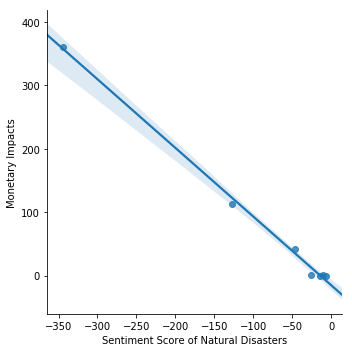

In [346]:
sns.lmplot(x = 'Sentiment Score of Natural Disasters', y = 'Monetary Impacts', data = sentiment_result)